## Sentiment Analysis of IMDB Movie Reviews

In [ ]:
#Load the libraries

import os
import re
import nltk
import spacy
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score


nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer


# from sklearn.preprocessing import LabelBinarizer

# from nltk.tokenize import word_tokenize,sent_tokenize
# import re,string,unicodedata

# from nltk.stem import LancasterStemmer,WordNetLemmatizer
# from sklearn.linear_model import LogisticRegression,SGDClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import SVC
# from textblob import TextBlob
# from textblob import Word
from sklearn.metrics import classification_report

[nltk_data] Downloading package wordnet to /Users/macbook/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/macbook/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Datasets

In [8]:
df=pd.read_csv('data/IMDB_Dataset.csv')
print(df.shape)
df.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Extract basic info from the dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [10]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [11]:
# Find missing values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [12]:
# This checks for data imbalance
print('positive consists of', round(df['sentiment'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('negative consists of', round(df['sentiment'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

positive consists of 50.0 % of the dataset
negative consists of 50.0 % of the dataset


#### Investigate what kind of special characters used by the reviewers to review the content. 

In [13]:
review = df['review'].loc[10]
review

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'

##### It can be observed that the data has html tags, special characters, uppercase(not necessary when using stopwords)

# Data Cleaning

#### removing html contents

In [14]:
def remove_html_tags(text):
    text=re.sub('<.*?>',' ',text)
    return text
review = remove_html_tags(review)
review

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.  At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.  Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.  I imagine this film would appeal to a stoner who is currently partaking.  For something similar but better try "Brother from another planet"'

#### removing special characters

In [15]:
def remove_special_characters(text):
    pattern=r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    text = re.sub('\[[^]]*\]', '', text)
    return text
review = remove_special_characters(review)
review

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines  At first it was very odd and pretty funny but as the movie progressed I didnt find the jokes or oddness funny anymore  Its a low budget film thats never a problem in itself there were some pretty interesting characters but eventually I just lost interest  I imagine this film would appeal to a stoner who is currently partaking  For something similar but better try Brother from another planet'

#### Convert to lowercase

In [16]:
def to_lowercase(text):
    return text.lower()
review = to_lowercase(review)
review

'phil the alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines  at first it was very odd and pretty funny but as the movie progressed i didnt find the jokes or oddness funny anymore  its a low budget film thats never a problem in itself there were some pretty interesting characters but eventually i just lost interest  i imagine this film would appeal to a stoner who is currently partaking  for something similar but better try brother from another planet'

#### unify whitespaces

In [17]:
def unify_whitespaces(text):  
    text = re.sub(" +", " ", text)
    return text
review = unify_whitespaces(review)
review

'phil the alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines at first it was very odd and pretty funny but as the movie progressed i didnt find the jokes or oddness funny anymore its a low budget film thats never a problem in itself there were some pretty interesting characters but eventually i just lost interest i imagine this film would appeal to a stoner who is currently partaking for something similar but better try brother from another planet'

#### removing the stopwords

In [18]:
def remove_stopwords(text):
    text = text.split()
    text = [word for word in text if not word in set(stopwords.words('english'))]
    return text
review = remove_stopwords(review)
review

['phil',
 'alien',
 'one',
 'quirky',
 'films',
 'humour',
 'based',
 'around',
 'oddness',
 'everything',
 'rather',
 'actual',
 'punchlines',
 'first',
 'odd',
 'pretty',
 'funny',
 'movie',
 'progressed',
 'didnt',
 'find',
 'jokes',
 'oddness',
 'funny',
 'anymore',
 'low',
 'budget',
 'film',
 'thats',
 'never',
 'problem',
 'pretty',
 'interesting',
 'characters',
 'eventually',
 'lost',
 'interest',
 'imagine',
 'film',
 'would',
 'appeal',
 'stoner',
 'currently',
 'partaking',
 'something',
 'similar',
 'better',
 'try',
 'brother',
 'another',
 'planet']

#### Stemming the text

In [19]:
def text_stemming(text):
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text]
    return ' '.join(text) 
stem_review = text_stemming(review)
stem_review

'phil alien one quirki film humour base around odd everyth rather actual punchlin first odd pretti funni movi progress didnt find joke odd funni anymor low budget film that never problem pretti interest charact eventu lost interest imagin film would appeal stoner current partak someth similar better tri brother anoth planet'

#### Lemmatizing the text

In [280]:
def text_lemmatizing(text):
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text]
    return ' '.join(text) 
lem_review = text_lemmatizing(review)
lem_review

'phil alien one quirky film humour based around oddness everything rather actual punchlines first odd pretty funny movie progressed didnt find joke oddness funny anymore low budget film thats never problem pretty interesting character eventually lost interest imagine film would appeal stoner currently partaking something similar better try brother another planet'

#### From the result of both stemming and lemmatizing shows lemmatizing to still retain the structure of the reviews better that stemming 

In [310]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [311]:
def preprocessing(df):
    df['review']=df['review'].apply(remove_html_tags)
    df['review']=df['review'].apply(remove_special_characters)
    df['review']=df['review'].apply(to_lowercase)
    df['review']=df['review'].apply(unify_whitespaces)
    df['review']=df['review'].apply(remove_stopwords)
    df['review']=df['review'].apply(text_lemmatizing)
    return df
df_final = preprocessing(df)

In [314]:
df_final.review[10]

'phil alien one quirky film humour based around oddness everything rather actual punchlines first odd pretty funny movie progressed didnt find joke oddness funny anymore low budget film thats never problem pretty interesting character eventually lost interest imagine film would appeal stoner currently partaking something similar better try brother another planet'

#### Word summary of positive reviews

(-0.5, 399.5, 199.5, -0.5)

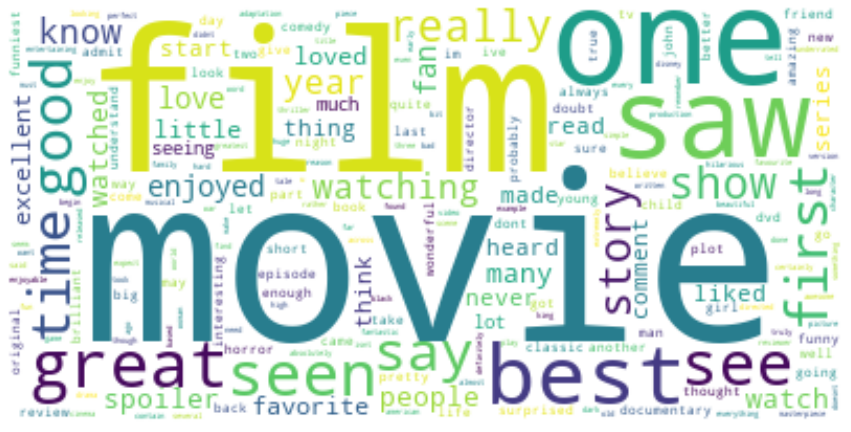

In [360]:
positive =  df_final[df_final['sentiment'] == 1]

text = " ".join(cat.split()[1] for cat in positive.review)
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")

#### Word summary of negative reviews

(-0.5, 399.5, 199.5, -0.5)

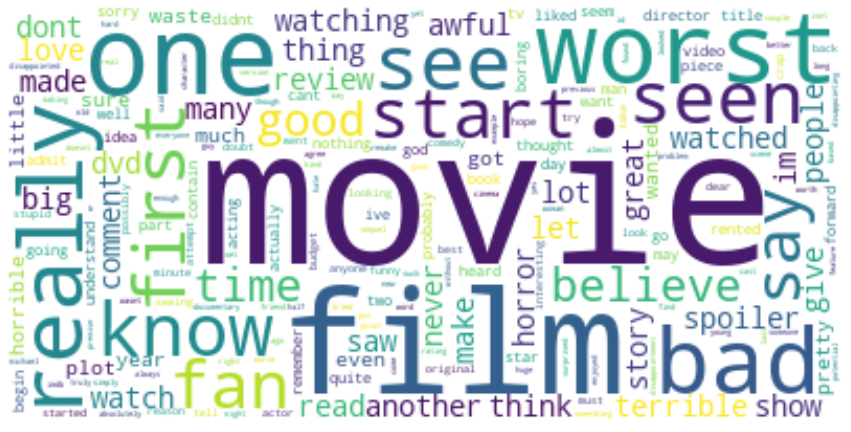

In [361]:
negative =  df_final[df_final['sentiment'] == 0]

text = " ".join(cat.split()[1] for cat in negative.review)
wordcloud = WordCloud(background_color='white').generate(text)
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")

# Label encoding 

In [ ]:
label_encoder = LabelEncoder()
df_final['sentiment'] = label_encoder.fit_transform(df_final['sentiment'])

## Split the data into test and train dataset

In [493]:
x_train, x_test, y_train, y_test = train_test_split(df_final.review, df_final.sentiment, test_size=0.30, random_state=2)

#### Here 70% of the data is taken as training data snd 30% is used for testing 

# Word Vectorization

In [197]:
#Count vectorizer for bag of words
cv = CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
# cv_train = cv.fit_transform(X_train)


BOW_cv_train: (35000, 5452818)
BOW_cv_test: (15000, 5452818)


#### Note that it contains 50k rows so its a mid-sized database so we expect the TF-IDF based model to work better than deep learning models. 

#### We will use pre-built TF-IDF vectorizer from sklearn library. Let us create a document term matrix (DTM) using TF-IDF.

In [502]:
# Tfidf vectorizer
vectorizer = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
# tfidf_fit = tfidf.fit(df_final.review)
# tfidf_train = tfidf.transform(df_final.review)

# Modelling

In [504]:
# modelling
LR = LogisticRegression()
pipeline = make_pipeline(vectorizer, LR)
pipeline.fit(x_train, y_train)
predict = pipeline.predict(x_test)

# Evaluation metrics
accuracy_score = metrics.accuracy_score(predict, y_test)
print("LR = " + str('{:04.2f}'.format(accuracy_score*100))+" %")
print("Classification Report: \n", classification_report(y_test, predict,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict))

LR = 89.85 %
Classification Report: 
               precision    recall  f1-score   support

    Negative       0.91      0.89      0.90      7499
    Positive       0.89      0.91      0.90      7501

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000

Confusion Matrix: 
 [[6638  861]
 [ 662 6839]]


#### The above metric shows the Accuracy, Sensitivity, precision in confusion matrix. Classification report shows that the performance of the model is not bad. Accuracy as a metric may be misleading sometimes. However here the accuracy, precision and recall are almost similar. So accuracy can be the major evaluation metric

#### Accuracy is 89.85%

Precision: Out of all the sentiments that the model predicted Positive, only 89% actually did.

Recall / Sensitivity: Out of all the sentiments that actually did get positiv reviews, the model only predicted this outcome correctly for 91% of those time.

Support: is the number of occurence of the given class in your dataset (here 7499 of Negative and 7501 of Positive, which is a really well balanced dataset)

Here the model has a high False positive value
#### NB: precision and recall is highly used for imbalanced dataset because in an highly imbalanced dataset. So here we will be focusing on accuracy score majorly since the dataset is balanced.

In [505]:
MNB = MultinomialNB()
pipeline = make_pipeline(vectorizer, MNB)
pipeline.fit(x_train, y_train)
predict = pipeline.predict(x_test)
accuracy_score = metrics.accuracy_score(predict, y_test)
print("Multinomial Naive Bayes accuracy = " + str('{:04.2f}'.format(accuracy_score*100))+" %")
print("Classification Report: \n", classification_report(y_test, predict,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict))

Multinomial Naive Bayes accuracy = 88.97 %
Classification Report: 
               precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      7499
    Positive       0.89      0.89      0.89      7501

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

Confusion Matrix: 
 [[6680  819]
 [ 835 6666]]


In [515]:
LSVC = LinearSVC()
pipeline = make_pipeline(vectorizer, LSVC)
pipeline.fit(x_train, y_train)
predict = pipeline.predict(x_test)
accuracy_score = metrics.accuracy_score(predict, y_test)
print("Linear SVC accuracy = " + str('{:04.2f}'.format(accuracy_score*100))+" %")
print("Classification Report: \n", classification_report(y_test, predict,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict))

Linear SVC accuracy = 91.21 %
Classification Report: 
               precision    recall  f1-score   support

    Negative       0.92      0.90      0.91      7499
    Positive       0.90      0.92      0.91      7501

    accuracy                           0.91     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.91      0.91      0.91     15000

Confusion Matrix: 
 [[6767  732]
 [ 586 6915]]


In [507]:
SGDC = SGDClassifier()
pipeline = make_pipeline(vectorizer, SGDC)
pipeline.fit(x_train, y_train)
predict = pipeline.predict(x_test)
accuracy_score = metrics.accuracy_score(predict, y_test)
print("Stocastic Gradient Classifier accuracy = " + str('{:04.2f}'.format(accuracy_score*100))+" %")
print("Classification Report: \n", classification_report(y_test, predict,target_names=['Negative','Positive']))
print("Confusion Matrix: \n", confusion_matrix(y_test, predict))

Stocastic Gradient Classifier accuracy = 90.00 %
Classification Report: 
               precision    recall  f1-score   support

    Negative       0.91      0.88      0.90      7499
    Positive       0.89      0.92      0.90      7501

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000

Confusion Matrix: 
 [[6629  870]
 [ 630 6871]]


# Save model and tfidf 

In [521]:
# save your model in disk
joblib.dump(pipeline, 'Models/model.pkl')

['Models/model.pkl']

In [522]:
def tfidf_preprocessing(text):
    text =remove_html_tags(text)
    text = remove_special_characters(text)
    text = to_lowercase(text)
    text = unify_whitespaces(text)
    text = remove_stopwords(text)
    text = text_lemmatizing(text)
    return text

In [527]:
text = "Good review"
text = tfidf_preprocessing(text)
text

'good review'

In [528]:
# Load the model from the file
# model = joblib.load('Models/model.pkl')
 
# Use the loaded model to make predictions
model.predict([text])

array([0])

In [532]:
df = preprocessing(df)

In [542]:
df.to_csv('mongo_volume/cleaned_data.csv', index=False)

In [541]:
df

,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
49995,thought movie right good job wasnt creative or...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,im going disagree previous comment side maltin...,negative
